In [1]:
from phi.torch.flow import *
import torch

device = torch.device('cuda')

In [2]:
BOUNDS = Box(x=1, y=1)
RESOLUTION = 10

In [3]:
ORIGIN_DENSITY_FIELD = CenteredGrid(
    values=Noise(),
    extrapolation=extrapolation.ZERO_GRADIENT,
    bounds=BOUNDS,
    resolution=spatial(x=RESOLUTION, y=RESOLUTION),
)
TARGET_DENSITY_FIELD = CenteredGrid(
    values=Noise(),
    extrapolation=extrapolation.ZERO_GRADIENT,
    bounds=BOUNDS,
    resolution=spatial(x=RESOLUTION, y=RESOLUTION),
)
ORIGIN_VELOCITY_FIELD = StaggeredGrid(
    values=Noise(),
    extrapolation=extrapolation.ZERO_GRADIENT,
    bounds=BOUNDS,
    resolution=spatial(x=RESOLUTION, y=RESOLUTION),
)

In [4]:
x = torch.linspace(0.2, 0.8, 3, dtype=torch.float32, device=device, requires_grad=True)
y = torch.linspace(0.2, 0.8, 3, dtype=torch.float32, device=device, requires_grad=True)
grid_x, grid_y = torch.meshgrid(x, y, indexing='ij')
LOC_SRC = torch.stack([grid_x, grid_y], dim=-1).reshape(-1, 2)  # [9, 2]
LOCATIONS = wrap(LOC_SRC, instance('locations'), channel(vector='x,y'))
DIRECTIONS = math.random_normal(LOCATIONS.shape)

print(LOCATIONS)
print(DIRECTIONS)

(locationsⁱ=9, vectorᶜ=x,y) 0.500 ± 0.245 (2e-01...8e-01)
(locationsⁱ=9, vectorᶜ=x,y) 0.160 ± 1.010 (-1e+00...2e+00)


In [5]:
A = 0.2
sigma = 0.2


def simulate(in_den, in_vel, in_dt, in_force):
    out_vel = in_vel + resample(in_force, to=in_vel) * in_dt
    out_den = advect.mac_cormack(in_den, out_vel, in_dt)
    # out_vel = advect.semi_lagrangian(in_vel, in_vel, in_dt)
    return out_den, out_vel


@jit_compile
def loss_function(in_loc, in_dir):
    GAUSS_FORCE_FIELD = CenteredGrid(
        values=lambda x, y: sum(
            math.exp(-length(in_loc.locations[i] - vec(x=x, y=y)) ** 2 / (2 * sigma ** 2)) * in_dir.locations[i]
            for i in range(instance(in_loc).size)
        ),
        extrapolation=extrapolation.ZERO_GRADIENT,
        bounds=BOUNDS,
        resolution=spatial(x=RESOLUTION, y=RESOLUTION),
    )
    iter_den, iter_vel = ORIGIN_DENSITY_FIELD, ORIGIN_VELOCITY_FIELD
    iter_den, iter_vel = simulate(iter_den, iter_vel, 0.2, GAUSS_FORCE_FIELD)
    return math.l2_loss(iter_den.values - TARGET_DENSITY_FIELD.values)


grad_fun = math.gradient(loss_function, wrt='in_loc, in_dir', get_output=True)


def gradient_descent_step(in_loc, in_dir, learning_rate=.0001):
    out_loss, (d_loc, d_dir) = grad_fun(in_loc, in_dir)
    return out_loss, in_loc - learning_rate * d_loc, in_dir - learning_rate * d_dir

In [6]:
import tqdm

losses = []
train_loc = LOCATIONS
train_dir = DIRECTIONS
for _ in tqdm.trange(10000):
    loss, train_loc, train_dir = gradient_descent_step(train_loc, train_dir)
    losses.append(loss)

100%|██████████| 10000/10000 [01:57<00:00, 84.84it/s]


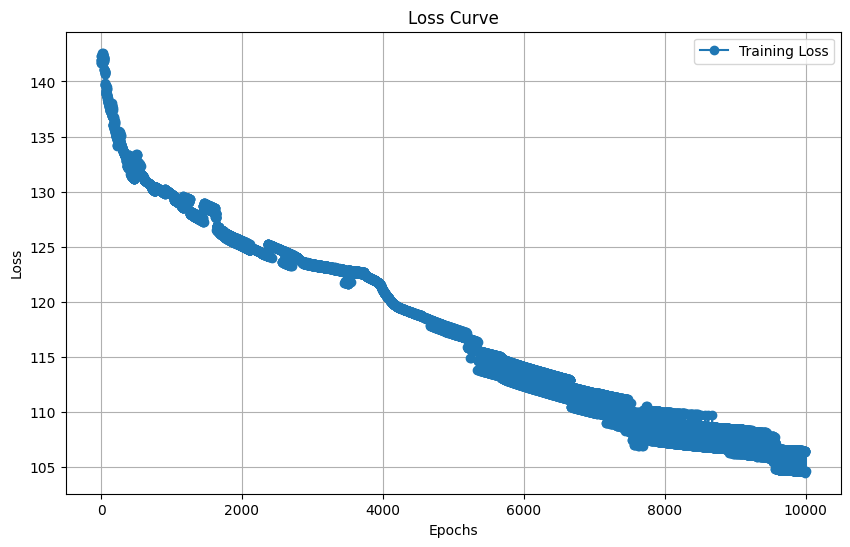

In [7]:
import matplotlib.pyplot as plt

# 绘制损失曲线
plt.figure(figsize=(10, 6))
plt.plot(losses, label="Training Loss", linestyle='-', marker='o')  # 使用线条和标记
plt.xlabel("Epochs")  # 横轴标签
plt.ylabel("Loss")  # 纵轴标签
plt.title("Loss Curve")  # 图标题
plt.legend()  # 显示图例
plt.grid(True)  # 添加网格
plt.show()